In [2]:
from pathlib import Path
PATH_DATA = Path().resolve() / 'data'
PATH_DATA.mkdir(exist_ok=True)

In [3]:
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 250 kB 15.2 MB/s 
     |████████████████████████████████| 1.9 MB 31.1 MB/s 
     |████████████████████████████████| 1.3 MB 59.2 MB/s 
     |████████████████████████████████| 5.3 MB 54.5 MB/s 
     |████████████████████████████████| 441 kB 68.1 MB/s 
     |████████████████████████████████| 7.6 MB 48.1 MB/s 
     |████████████████████████████████| 9.2 MB 58.7 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 163 kB 68.2 MB/s 
     |████████████████████████████████| 166 kB 67.4 MB/s 
     |████████████████████████████████| 182 kB 69.8 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 166 kB 75.7 MB/s 
     |████████████████████████████████| 162 kB 62.3 MB/s 
     |████████████████████████████████| 162 kB 77.2 MB/s 
     |█████████████████████████████

In [7]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

# Optional model configuration
model_args = ClassificationArgs()
model_args.num_train_epochs=1
model_args.overwrite_output_dir=True
model_args.learning_rate=2e-05

model = ClassificationModel("bert", "bert-base-uncased", args=model_args,use_cuda=True)
#model = ClassificationModel("bert", "diptanu/fBERT", args=model_args,use_cuda=True)
#model = ClassificationModel("bert", "GroNLP/hateBERT", args=model_args,use_cuda=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [8]:
import pandas as pd
df_train_olid_small = pd.read_csv(PATH_DATA / 'df_train_olid_small_features.csv')
df_train_hasoc = pd.read_csv(PATH_DATA / 'df_train_hasoc_features.csv')
df_test_olid = pd.read_csv(PATH_DATA / 'df_test_olid_features.csv')

In [9]:
model.train_model(df_train_olid_small)

  0%|          | 0/5852 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/732 [00:00<?, ?it/s]

(732, 0.5614529906726274)

In [10]:
result, model_outputs, wrong_predictions = model.eval_model(df_test_olid)

  0%|          | 0/860 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/108 [00:00<?, ?it/s]

In [11]:
from sklearn.metrics import classification_report
import numpy as np

print(classification_report(
    y_true=df_test_olid['labels'],
    y_pred=np.argmax(model_outputs, axis=1)
))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       620
           1       0.72      0.68      0.70       240

    accuracy                           0.84       860
   macro avg       0.80      0.79      0.79       860
weighted avg       0.83      0.84      0.83       860



In [12]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(df_test_olid['labels'],np.argmax(model_outputs, axis=1))

print(cf_matrix)

[[556  64]
 [ 77 163]]


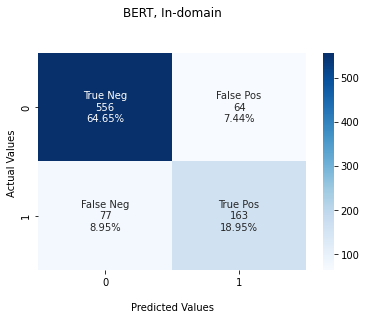

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('BERT, In-domain\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()